# Imports and definitions

In [1]:
from utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'

file_xrd         = path_scan + 'ProfiloXRD/Frame5060.dat'   # XRD scan
file_calibration = path_scan + 'ProfiloXRD/calibration.ini'

file_xrf = path_scan + 'P1Bianco100s.spe'     # XRF scan

path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'output/MunchMuseum/M491/Profilo/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script
path_phases_check = path_figures + 'phases_check/'
path_results = subfolder_output + 'results/'            # results generated by the script: raw data, tif maps
path_calibrations = subfolder_output + 'calibrations/'  # calibrated XRD spectra

pahts_to_create_delete = [path_figures, path_phases_check, path_results, path_calibrations]

### Fit ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5    # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = True

if do_you_want_to_delete:
    for path_sel in pahts_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in pahts_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:', len(database))

Phases in database: 369


# Read and process XRD data

#### Parameters of the smoothing of XRD pattern
- `window_snip`: width of the window used for determining the background
- `offset_background`: value added to the background, before subtracting it from the raw signal
- `std_smooth`: degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

Loading '../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/Frame5060.dat'
Data length: 1280
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.54888119293563]


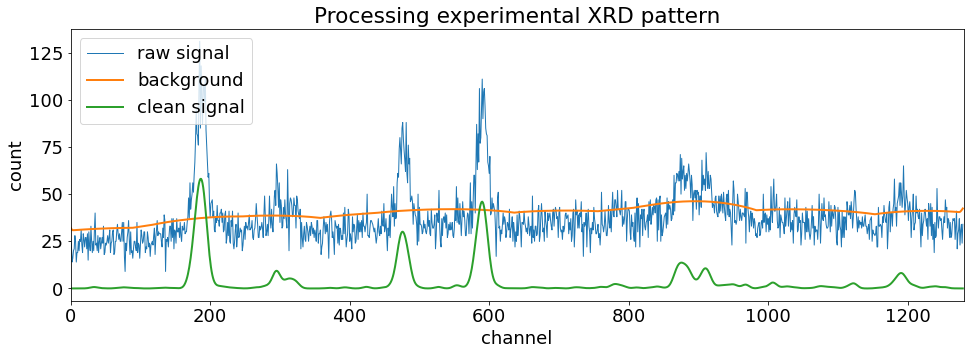

In [5]:
rcParams['font.size'] = 18

window_snip = 32         # default 32
offset_background = 10   # default 0
std_smooth = 5           # set 0 for no smooth

###

print(f'Loading \'{file_xrd}\'')
data_channels, data_count = loadtxt(file_xrd, unpack = True, dtype = 'int')
data_background = snip(convolve(data_count, n = 21, std = 3), m = window_snip)
background_shifted = data_background + offset_background
data_count_no_bg = maximum(data_count - background_shifted, 0)
data_count_smoothed = convolve(data_count_no_bg, n = ceil(3 * std_smooth + 1), std = std_smooth)
data_rescaling = data_count_smoothed.max()
data_intensity = data_count_smoothed / data_rescaling
calib = Calibration(FastSpectraXRD()).from_file(file_calibration)
print(f'Data length: {data_count.shape[0]}')
print('Initial calibration:')
print(f'a = {calib.opt[0]:.1f}, s = {calib.opt[1]:.1f}, beta = {calib.opt[2]:.3f}')
print(f'Theta range {list(calib.fce([data_channels[0], data_channels[-1]], *calib.opt))}')

spectrum_xrd = FastSpectraXRD().from_components(
    opt = calib.opt.copy(),
    counts = data_count,
    rescaling = data_rescaling,
    intensity = data_count_smoothed / nanmax(data_count_smoothed)
)

fig, ax = subplots(figsize = (16, 5))
ax.plot(data_count, lw = 1, label = 'raw signal')
ax.plot(background_shifted, lw = 2, label = 'background')
ax.plot(data_count_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 2)
ax.set_xlim(0, len(data_count))
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

# Read XRF spectrum

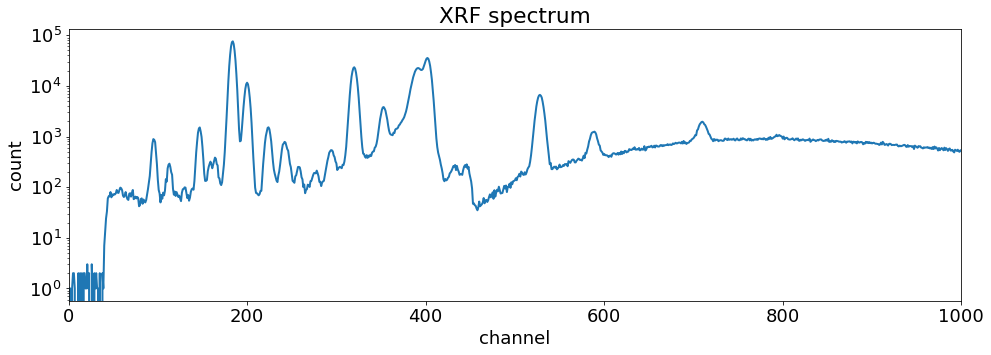

In [6]:
#limits_channel = [0, len(counts_xrf)]   # default limits
limits_channel = [0, 1000]              # custom limits

log_y_scale = True

counts_xrf = read_point_xrf(file_xrf)
fig, ax = subplots(figsize = (16, 5))
ax.plot(counts_xrf, lw = 2, label = 'raw signal')
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlim(*limits_channel)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('XRF spectrum')
show()

#limits_channel = [0, len(counts_xrf)]

# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [7]:
elements_chosen = ['Si', 'Al']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Aluminoceladonite,Al1.788 H2 K Mg0.64 O12 Si3.572,3
1,Attakolite,Al4 Ca H5 Mn O20 P3 Si,1
2,Celadonite,Al2 H2 K O12 Si4,5
3,Cyanide Sodalite,C2 Al6 N2 Na16 O24 Si6,1
4,Glauconite,Al2 H2 K O12 Si4,3
5,Kalsilite,Al K O4 Si,1
6,Kaolin,Al2 H4 O9 Si2,1
7,Kaolinite 2M,Al2 H4 O9 Si2,1
8,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,4
9,Metahalloysite,Al2 H4 O9 Si2,1


### Fit selected phases on experimental XRD pattern

In [8]:
list_overlap = []
list_overlap_avg = []
list_overlap_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    
    gs = GammaSearch([p for p in phase_set], spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gs = gs.fit_cycle(gamma = True, steps = 10)
    overlap = gs.overlap3_area_ratio()
    list_overlap.append(overlap)

df_phases['Best overlap'] = [nanmax(list_overlap[i]) for i in range(df_phases.shape[0])]
df_phases.style.format({'Best overlap': '{:.3f}'})

,Name in database,Chemical formula,N. of samples,Best overlap
0,Aluminoceladonite,Al1.788 H2 K Mg0.64 O12 Si3.572,3,0.133
1,Attakolite,Al4 Ca H5 Mn O20 P3 Si,1,0.065
2,Celadonite,Al2 H2 K O12 Si4,5,0.083
3,Cyanide Sodalite,C2 Al6 N2 Na16 O24 Si6,1,0.054
4,Glauconite,Al2 H2 K O12 Si4,3,0.102
5,Kalsilite,Al K O4 Si,1,0.034
6,Kaolin,Al2 H4 O9 Si2,1,0.010
7,Kaolinite 2M,Al2 H4 O9 Si2,1,0.008
8,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,4,0.528
9,Metahalloysite,Al2 H4 O9 Si2,1,0.285


### Select phase samples as primary or secondary phases
- `thresholds_overlap_avg`. If avg overlap of a phase is above the second threshold, the phase can be selected as primary. Otherwise, if avg overlap is above the first threshold, the phase can be selected as secondary.

##### Note
If a phase is selected as primary, it is prevented from being selected as secondary, even with a different sample.

In [9]:
thresholds_overlap = [0.1, 0.3]

list_sel_category = []
list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_overlap = []

for i in range(df_phases.shape[0]):
    idx = (list_overlap[i] >= thresholds_overlap[1])
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_overlap_filtered = list_overlap[i][idx]
        j = nanargmax(arr_overlap_filtered)
        
        list_sel_category.append('Primary')
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_overlap.append(arr_overlap_filtered[j])
    else:
        idx = (list_overlap[i] >= thresholds_overlap[0])
        if any(idx):
            arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
            arr_overlap_filtered = list_overlap[i][idx]
            j = nanargmax(arr_overlap_filtered)

            list_sel_category.append('Secondary')
            list_sel_name.append(df_phases.loc[i, 'Name in database'])
            list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
            list_sel_sample.append(arr_sample_filtered[j])
            list_sel_overlap.append(arr_overlap_filtered[j])

df_phases_sel = DataFrame({
    'Category': list_sel_category,
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Overlap': list_sel_overlap,
})
df_phases_sel = df_phases_sel.sort_values(by = ['Category', 'Phase']).reset_index(drop = True)
df_phases_sel.style.format({'Overlap': '{:.3f}'})

,Category,Phase,Formula,Sample,Overlap
0,Primary,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,0,0.528
1,Secondary,Aluminoceladonite,Al1.788 H2 K Mg0.64 O12 Si3.572,1,0.133
2,Secondary,Glauconite,Al2 H2 K O12 Si4,2,0.102
3,Secondary,Metahalloysite,Al2 H4 O9 Si2,0,0.285
4,Secondary,Sodalite,Al6 Cl2 Na8 O24 Si6,20,0.230


### Add selected phases to their appropriate files

This cell writes the list of names of selected phases into the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`. If the files do not exist, the cell creates them.

In [10]:
for category in ['Primary', 'Secondary']:
    filename = f'{subfolder_output}phases_selection_{category.lower()}.dat'
    df_phases_sel.loc[df_phases_sel['Category'] == category, ['Phase', 'Formula', 'Sample', 'Overlap']]\
    .to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Delete the files with list of selected phases
Delete the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`.

In [11]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for file_name in ['phases_selection_primary.dat', 'phases_selection_secondary.dat']:
        if exists(subfolder_output + file_name):
            remove(subfolder_output + file_name)

# Check phases

### Specific phase vs experimental XRD pattern

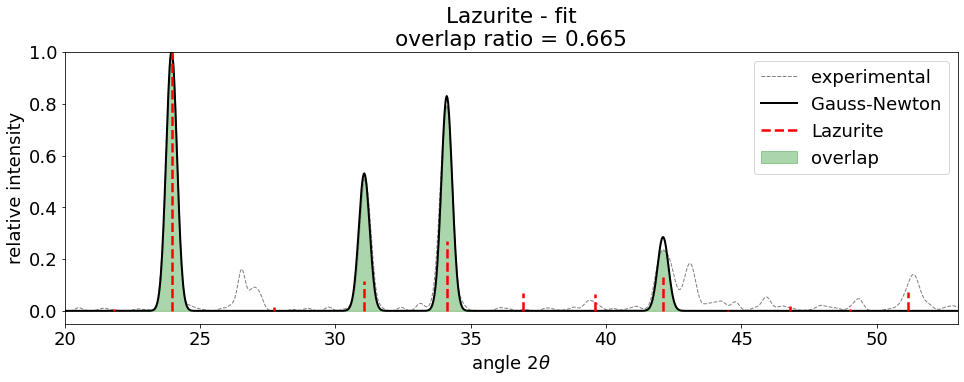

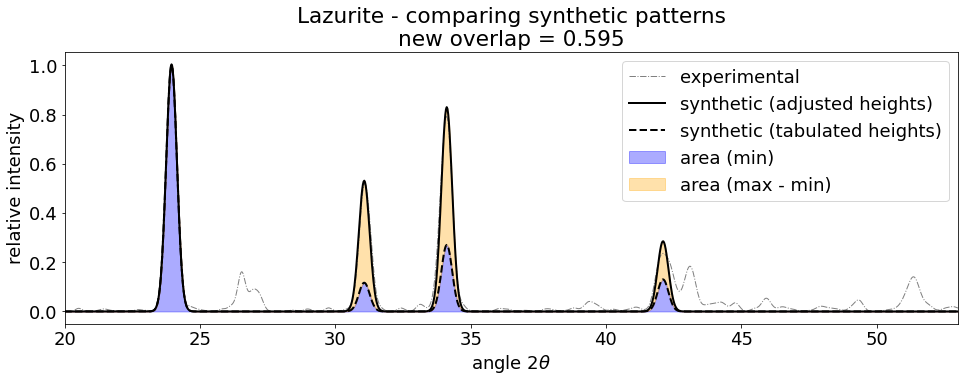

In [12]:
rcParams['font.size'] = 18

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Lazurite'][0]

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = database['Lazurite'][0]

# The diffraction lines of this phase will be shown for comparison. Set to None in order to have no comparison.
#phase_comparison = database['Hydrocerussite'][0]
phase_comparison = None


### Fit ###

gn = GaussNewton(phase_check, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt.copy()

gn.fit_cycle(gamma = True, steps = 10)

z_min = minimum(gn.z(), gn.z0())
z_max = maximum(gn.z(), gn.z0())
z_diff = abs(z_min - z_max)
overlap = z_min.sum() / z_max.sum()

### Plot ###

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.phase.plot(lw = 2.5, alpha = 1)
if phase_comparison is not None:
    phase_comparison.plot(color = 'tab:blue')
ax.fill_between(gn.theta, gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label} - fit\noverlap ratio = {gn.overlap3_area_ratio():.3f}')
show()

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, gn.z(), c = 'black', ls = '-', lw = 2, label = 'synthetic (adjusted heights)')
ax.plot(gn.theta, gn.z0(), c = 'black', ls = '--', lw = 2, label = 'synthetic (tabulated heights)')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (max - min)')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label} - comparing synthetic patterns\nnew overlap = {overlap:.3f}')
show()

### List of phases vs experimental XRD pattern (and save figures)

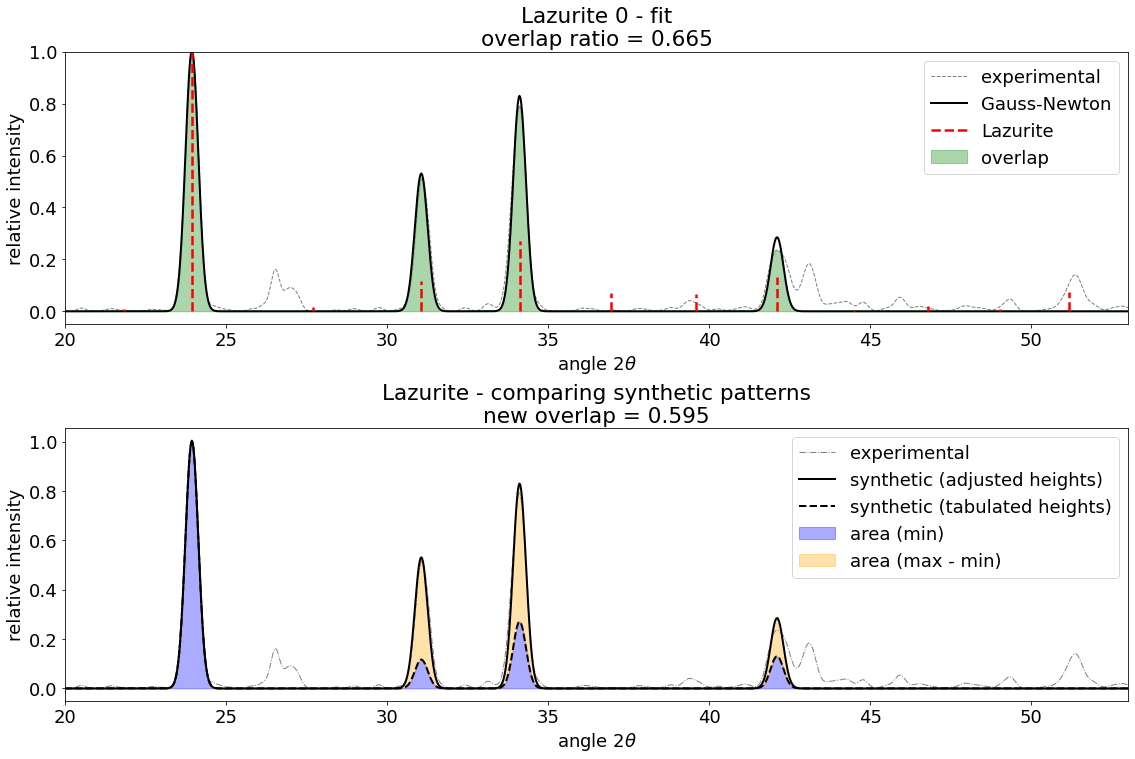

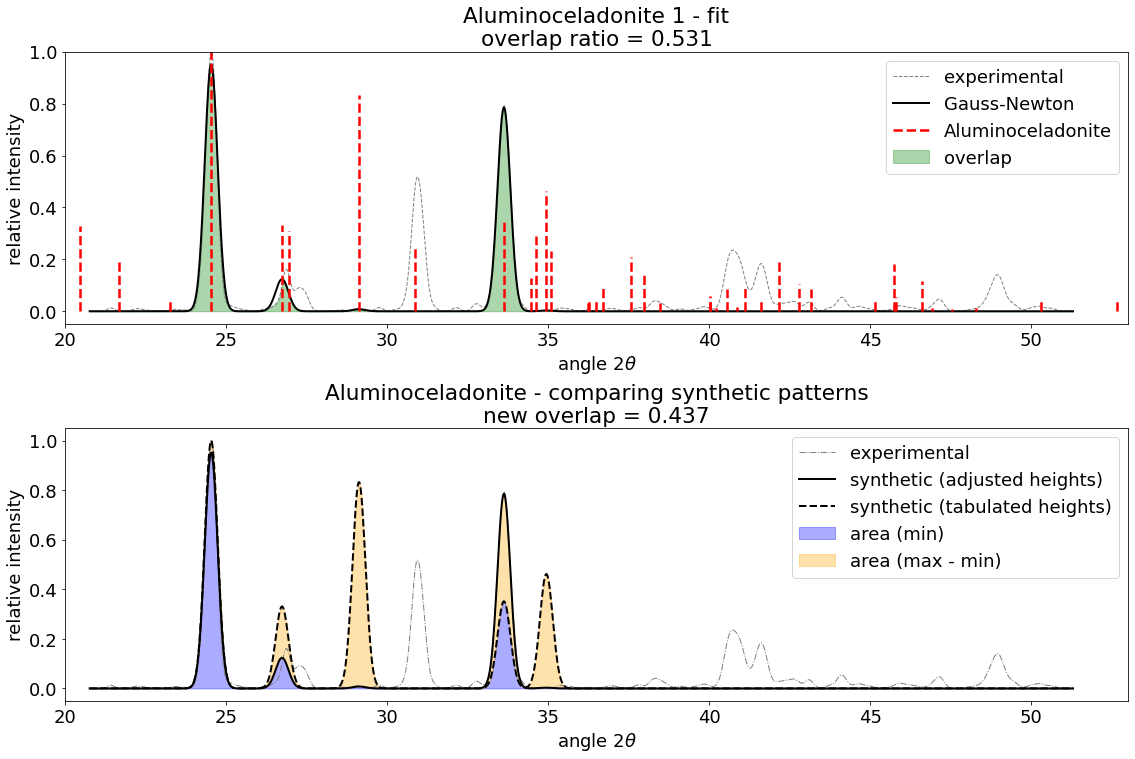

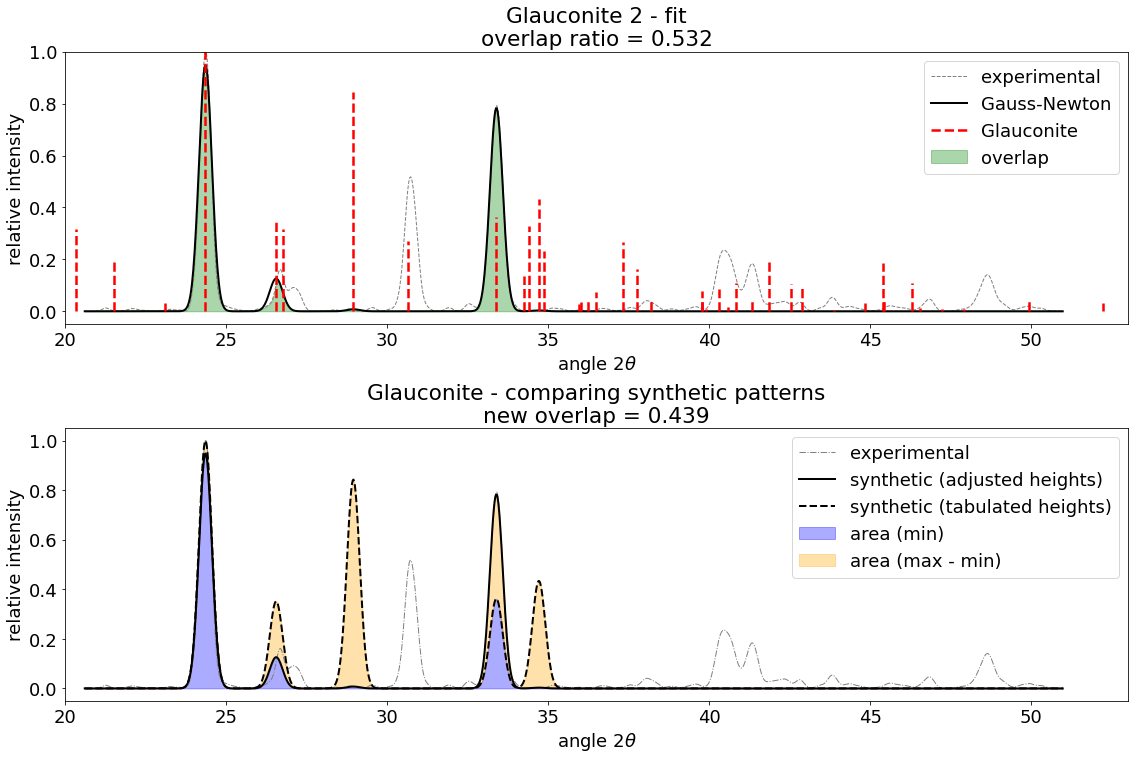

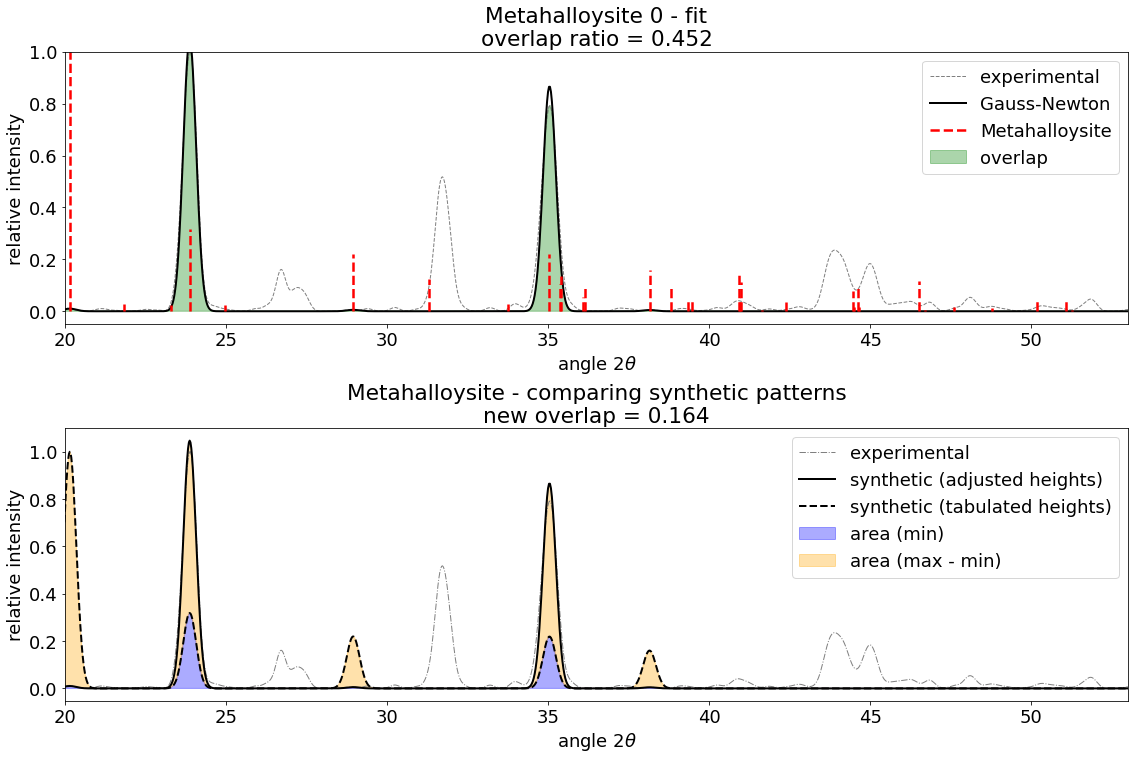

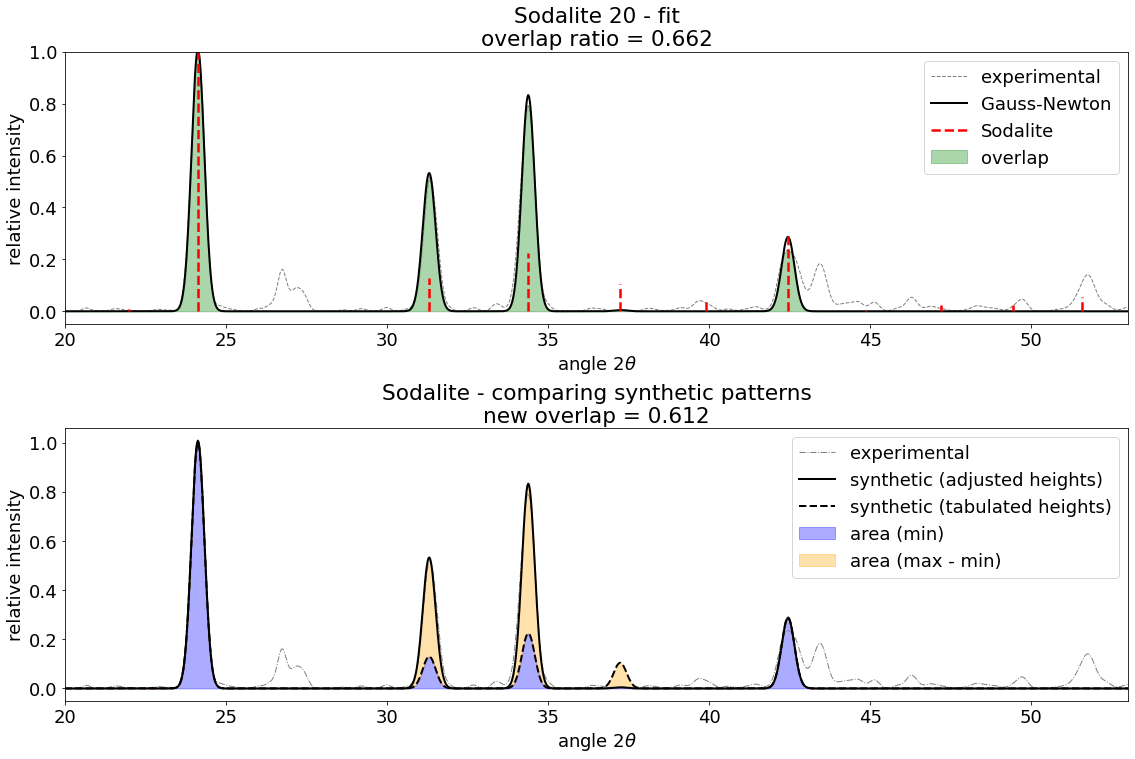

In [13]:
rcParams['font.size'] = 18

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Lazurite'][0]
phase_calibration = None

###

for i in range(df_phases_sel.shape[0]):
    
    ### Fit ###
    
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase_check = database[phase_name][phase_sample]

    gn = GaussNewton(phase_check, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    
    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt.copy()
        
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd_calibrated_with_{clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
    
    gn.fit_cycle(gamma = True, steps = 16)

    z_min = minimum(gn.z(), gn.z0())
    z_max = maximum(gn.z(), gn.z0())
    z_diff = abs(z_min - z_max)
    overlap = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(2, 1, figsize = (16, 10))
    fig.tight_layout(h_pad = 4)
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.phase.plot(lw = 2.5, alpha = 1)
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'{phase_name} {phase_sample} - fit\noverlap ratio = {gn.overlap3_area_ratio():.3f}')
    
    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, gn.z(), c = 'black', ls = '-', lw = 2, label = 'synthetic (adjusted heights)')
    ax.plot(gn.theta, gn.z0(), c = 'black', ls = '--', lw = 2, label = 'synthetic (tabulated heights)')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (max - min)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'{gn.label} - comparing synthetic patterns\nnew overlap = {overlap:.3f}')
    
    savefig(f'{path_phases_check}{clean_phase_name(phase_name)} check_fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)